# Trabalho de Conclusão de Curso II
**Aluno: Diogo de Paula Almazan** <br/>
**Engenharia de Sistemas - UFMG**<br/>
**Data: 2021/2**

## Bibliotecas

In [1]:
# Importação das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt

## Funções Úteis

In [87]:
def JoinMachineAndExecutionTime(vetor):
    resultado = []
    tamanho = len(vetor)
    i = 0
    while i < tamanho:
        resultado.append([vetor[i],vetor[i+1]])
        i = i + 2
    return resultado

def convertArrayToMatrix(data):
    dadosFormatados = []
    for item in data:
        dadosFormatados.append(JoinMachineAndExecutionTime(item.split()))
    return dadosFormatados

def compareFitnessAndReplaceOrNot(referentialFitness, currentFitness, currentVector, referentialVector):
    """
        Compare the currentFitness calculated and the referential fitness. If the currentFitness is smaller than the referential value, return current. If not, return the referential value.
    """
    if(currentFitness <= referentialFitness):
        return [currentFitness, currentVector]
    else:
        return [referentialFitness, referentialVector]

def analyzeDiversityBetweenSamples(firstSample, secondSample, iteration):
    count = 0
    if(iteration != 0 ):
        for i in range(0, len(firstSample)):
            if(np.any(firstSample[i] != secondSample[i])):
                count += 1
    return count

def generateRandomIterationNumber(numberOfIterations):
    return np.random.randint(numberOfIterations)

def generateRandomNumbers(numberOfIterations, howManyValues):
    return np.random.choice(numberOfIterations, howManyValues, replace=False)

def copyArray(arrayToCopy):
    return arrayToCopy.copy()

def calculateLinearNorma(currentValue, maxValue, minValue):
    if(maxValue - minValue == 0): 
        return 0
    return (currentValue - minValue)/(maxValue - minValue)

## Leitura e formatação dos dados

In [3]:
def readInstanceAndReturnDataTaskMachines(fileWithDirectory):
    """
        Read the instance file and return data, besides the number of tasks and machines for the instance.
    """
    with open(fileWithDirectory) as file:
        lines = file.read()
        
    dimensions = lines.split('\n')[0]
    data = lines.split('\n')[1:]

    tasks = int(dimensions.split()[0])
    machines = int(dimensions.split()[1])
    print('Número de tasks: ', tasks)
    print('Número de máquinas: ', machines)
    return [data, tasks, machines]


# Format data and print
def formatReadData(data):
    """
        Format data to manipulate what is needed.
    """
    dadosFormatados = convertArrayToMatrix(data)
    # print(dadosFormatados)

    # Printa para ver o resultado
    # for i in range(0, len(dadosFormatados)):
    #     print("Tarefa {}: {}".format(i+1, dadosFormatados[i]))

    # print("")
    # print("Exemplo para facilitar o entendimento")
    # print("Tarefa {}: {}".format(1, dadosFormatados[0]))
    # for i in range(0, len(dadosFormatados[0])):
    #     print("Tarefa {} -> Operação 1,{}: {} -> Máquina {} com tempo {}".format(i+1, i+1, dadosFormatados[0][i], dadosFormatados[0][i][0], dadosFormatados[0][i][1]))
    return dadosFormatados

## Calcula Aptidão e Decodifica Posição Candidata

In [4]:
def calculateFitness(posicaoCandidata, matrizOperacoesTempo):
    """
        Função para avaliar o desempenho do algoritmo
            Parâmetros:
                - posicaoCandidata: Vetor de N tarefas x M máquinas. Exemplo: [O11, 021,..]
                - matrizOperacoesTempo: Matriz N tarefas x M máquinas, onde cada posição é um array contendo a Máquina e seu Tempo. Exemplo: [['1', '20'], ['0', '15'],..]
    """
    numeroTarefas = len(matrizOperacoesTempo)
    numeroMaquinas = len(matrizOperacoesTempo[0])
    vetorTempoMaquinasEmExecucao = np.zeros(numeroMaquinas)
    vetorTarefasEmExecucao = np.zeros(numeroTarefas)
    # i[0] -> TAREFA
    # i[1] -> OPERACAO
    for i in posicaoCandidata:
        maquina = int(matrizOperacoesTempo[int(i[0]) - 1 ][int(i[1]) - 1][0])
        tempoMaquina = int(matrizOperacoesTempo[int(i[0]) - 1][int(i[1]) - 1][1])
        tempoAtualAuxiliar = max(vetorTempoMaquinasEmExecucao[maquina - 1], vetorTarefasEmExecucao[int(i[0]) - 1])
        vetorTempoMaquinasEmExecucao[maquina - 1] = tempoAtualAuxiliar + tempoMaquina
        vetorTarefasEmExecucao[int(i[0]) - 1] = max(vetorTempoMaquinasEmExecucao[maquina - 1], vetorTarefasEmExecucao[int(i[0]) - 1])
    return [max(vetorTempoMaquinasEmExecucao), np.argmax(vetorTempoMaquinasEmExecucao) + 1]

def decodeRealValuesToOperationSequence(vetorValoresReais, numeroTarefas, numeroMaquinas):
    """
        Função para decodificar um array de valores reais em operações
            Parâmetros:
                - vetorValoresReais: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
                - numeroTarefas: Número de tarefas do problema. 
                - numeroMaquinas: Número de máquinas do problema. 
    """
    # print(vetorValoresReais)
    vetorAuxiliarOrdenado = vetorValoresReais.copy()
    vetorAuxiliarOrdenado.sort()
    resultado = []
    matrizOperacoes = []
    for item in vetorValoresReais:
        resultado.append(list(vetorAuxiliarOrdenado).index(item) + 1)
    # print('resultado: {}'.format(resultado))
    countAux = np.ones(numeroTarefas)
    for item in resultado:
        contaArredondada = round((np.floor((item-1)/ numeroMaquinas)))
        matrizOperacoes.append([str(contaArredondada + 1), str(round(countAux[contaArredondada]))])
        countAux[contaArredondada] += 1
    return matrizOperacoes

## Estruturas de Vizinhança

In [5]:
# Função VND - Shift
def VND_shift(posicaoCandidata):
    """
        VND com estrutura de vizinhança Shift (Realoca a posição de uma operação numa mesma máquina)
            Parâmetros:
                - posicaoCandidata: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
    """
    # print(posicaoCandidata)
    copiaPosicaoCandidata = posicaoCandidata.copy()
    [posicaoElementoASerDeslocado, posicaoFutura] = np.random.randint(1, len(copiaPosicaoCandidata), 2)
    # print(posicaoElementoASerDeslocado)
    # print(posicaoFutura)
    elementoASerDeslocado = copiaPosicaoCandidata[posicaoElementoASerDeslocado]
    del(copiaPosicaoCandidata[posicaoElementoASerDeslocado])
    primeiraParteVetor = copiaPosicaoCandidata[:posicaoFutura]
    segundaParteVetor = copiaPosicaoCandidata[posicaoFutura:]
    return primeiraParteVetor + [elementoASerDeslocado] + segundaParteVetor
    
# Função VND - Switch
def VND_switch(posicaoCandidata):
    """
        VND com estrutura de vizinhança Switch (Troca a posição de duas operações numa mesma máquina)
            Parâmetros:
                - posicaoCandidata: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
    """
    # print(posicaoCandidata)
    copiaPosicaoCandidata = posicaoCandidata.copy()
    [primeiraPosicao, segundaPosicao] = np.random.randint(1, len(copiaPosicaoCandidata), 2)
    # print(primeiraPosicao)
    # print(segundaPosicao)
    primeiroElemento = copiaPosicaoCandidata[primeiraPosicao]
    copiaPosicaoCandidata[primeiraPosicao] = copiaPosicaoCandidata[segundaPosicao]
    copiaPosicaoCandidata[segundaPosicao] = primeiroElemento
    return copiaPosicaoCandidata

def VND_Swap(posicaoCandidata1, posicaoCandidata2):
    copiaPosicaoCandidata1 = posicaoCandidata1.copy()
    copiaPosicaoCandidata2 = posicaoCandidata2.copy()
    [primeiraPosicaoSorteada, segundaPosicaoSorteada] = np.random.randint(1, len(copiaPosicaoCandidata1), 2)
    elementoAuxiliar = copiaPosicaoCandidata1[primeiraPosicaoSorteada]
    copiaPosicaoCandidata1[primeiraPosicaoSorteada] = copiaPosicaoCandidata2[segundaPosicaoSorteada]
    copiaPosicaoCandidata2[segundaPosicaoSorteada] = elementoAuxiliar
    return [copiaPosicaoCandidata1, copiaPosicaoCandidata2]

# print('VND Switch')
# print(VND_switch(posicaoCandidataComValoresReais))

# print('')
# print('VND Shift')
# print(VND_shift(posicaoCandidataComValoresReais))
# # print('')
# print('Antes 1: {} e 2: {}'.format(primeiraPosicaoCandidataComValoresReais, segundaPosicaoCandidataComValoresReais))
# print('VND Shift')
# print(VND_Swap(primeiraPosicaoCandidataComValoresReais, segundaPosicaoCandidataComValoresReais))

In [6]:
def applyVNDMethod(VNDmethod, firstPositionVector, tasks, machines, referentialFitness, dadosFormatados, secondPositionVector = []):
    fitness = 9999999999
    i = 0
    limitIteration = tasks*machines
    resultedArray = []
    while((fitness > referentialFitness) and (i <= limitIteration)):
    # while((fitness > referentialFitness)):
        if (len(secondPositionVector) == 0):
            resultedPositionVector = VNDmethod(list(firstPositionVector))
            operationsConverted = decodeRealValuesToOperationSequence(resultedPositionVector, tasks, machines)
        else:
            resultedPositionVector = VNDmethod(list(firstPositionVector), list(secondPositionVector))
            operationsConverted = decodeRealValuesToOperationSequence(resultedPositionVector[:][:1], tasks, machines)
        fitness = calculateFitness(operationsConverted, dadosFormatados)[0]
        i = i + 1

    if(i > limitIteration):
        if (len(secondPositionVector) == 0):
            resultedArray = [referentialFitness, firstPositionVector]
        else:
            resultedArray = [referentialFitness, firstPositionVector, secondPositionVector]
    else:
        # List is empty
        if (len(secondPositionVector) == 0):
            resultedArray = [fitness, resultedPositionVector]
        else:
            resultedArray = [fitness, resultedPositionVector[0], resultedPositionVector[1]]
    return resultedArray

## Método Particle Swarm Optimization

In [7]:
def particleSwarmOptimizationMethod(positionVector, velocityVector, bestPersonal, bestGlobal, c1, c2, w):
    """
        Particle Swarm Optimization Method
            Parameters:
            - positionVector: Array that contains real values with D positions
            - velocityVector: Array that contains real values with D positions
            - bestPersonal: Real values array from the best personal position evaluated
            - globalPersonal: Real values array from the global personal position evaluated
            - c1: Constant
            - c2: Constant
            - w: Constant
    """
    personalFunction = c1 * np.random.rand() * (bestPersonal - positionVector)
    globalFunction = c2 * np.random.rand() * (bestGlobal - positionVector)
    nextVelocityVector = w * velocityVector + personalFunction + globalFunction
    nextPositionVector = positionVector + nextVelocityVector
    return [nextPositionVector, nextVelocityVector]

In [8]:
# Dados mockados para teste
posicaoCandidataTeste1 = np.array([['1','1'], ['3', '1'], ['2', '1'], ['3', '2'], ['1', '2'], ['2', '2'], ['3', '3'], ['2', '3'], ['1', '3']])
posicaoCandidataTeste2 = np.array([['3', '1'], ['1','1'], ['2', '1'], ['3', '2'], ['1', '2'], ['2', '2'], ['3', '3'], ['2', '3'], ['1', '3']])
matrizOperacoesTempoTeste = [[['1', '2'], ['2', '3'], ['3', '1']], [['2', '3'], ['1', '1'], ['3', '2']], [['2', '2'], ['3', '3'], ['1', '2']]]

# Dados mockados para decoding
primeiraPosicaoCandidataComValoresReais = [0.13, 0.75, 0.48, 0.57, 0.21, 0.37, 0.96, 0.42, 0.06]
segundaPosicaoCandidataComValoresReais = [0.2, 0.8, 0.41, 0.21, 0.47, 0.9, 0.71, 0.13, 0.06]

## Funções de Inicialização

In [9]:
def initializePositionAndVelocityArrays(numberOfParticles, dimension):
    desiredVelocityRange = 2
    positionMatrix = np.zeros((numberOfParticles, dimension))
    velocityMatrix = np.zeros((numberOfParticles, dimension))
    for i in range(0, numberOfParticles):
        positionMatrix[i] = np.random.rand(dimension)
        velocityMatrix[i] = np.random.rand(dimension)*desiredVelocityRange
    return [positionMatrix, velocityMatrix]

def initializeBestPersonalAndGlobalPositionVector(positionMatrix, velocityMatrix, numberOfParticles, tasks, machines, dadosFormatados):
    # Set  
    positionMatrixAux = copyArray(positionMatrix)
    velocityMatrixAux = copyArray(velocityMatrix)

    # Initialize vectors
    bestPersonalPositionVector = np.zeros((numberOfParticles, tasks*machines))
    bestPersonalFitness = np.zeros(numberOfParticles)

    # Set initial values of vectors
    for i in range(0, numberOfParticles):
        bestPersonalPositionVector[i] = copyArray(positionMatrixAux[i])
        decodedArray = decodeRealValuesToOperationSequence(bestPersonalPositionVector[i], tasks, machines)
        bestPersonalFitness[i] = calculateFitness(decodedArray, dadosFormatados)[0]

    # Find the best fitness value (the smallest value)
    indexOfBetterFitness = np.argmin(bestPersonalFitness)
    bestGlobalPositionVector = copyArray(positionMatrixAux[indexOfBetterFitness])

    # Evalue the array
    decodedArray = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
    bestGlobalFitness = calculateFitness(decodedArray, dadosFormatados)[0]

    # print('Initial bestGlobalPosition {}'.format(bestGlobalPositionVector))
    # print('Initial bestGlobalFitness {}'.format(bestGlobalFitness))
    return [bestPersonalPositionVector, bestPersonalFitness, bestGlobalPositionVector, bestGlobalFitness, positionMatrixAux, velocityMatrixAux]


## ✅ Execução do projeto

In [134]:
# Parameters
numberOfParticles = 50
c1 = 2
c2 = 2
w = 1
# Number of iterations
iterations = 100
# Statistic execution time
executionTimeQuantity = 10

# Percentage of samples from population that will apply VND method
percentageParticlesChoosen = 0.1
# Number of particle that will be chosen
numberOfParticleChoosen = int(numberOfParticles*percentageParticlesChoosen)
particlesChoosen = np.zeros(numberOfParticleChoosen + 1) # add 1 for the best position in each iteration

# Percentage of iterations that will apply VND method
percentageIterationsForVND = 0.05
# Number of particle that will be chosen
numberOfIterationsForVND = int(iterations*percentageIterationsForVND)
iterationsForVND = np.zeros(numberOfIterationsForVND)

# Array de cores - Gráficos
colors = ['blue', 'red', 'green']

optimalValueArrayJSSPInstance = {'la01': 666, 'la02': 655, 'la03': 597, 'la04': 590, 'la05': 593, 'la06': 926, 'mt10': 930, 'mt20': 1165}
JSSPInstance = 'mt20'

In [135]:
# Full Method
[data, tasks, machines] = readInstanceAndReturnDataTaskMachines('./instances/{}.txt'.format(JSSPInstance))
dadosFormatados = formatReadData(data)

## Neighborhood Structures sequence
neighborhoodStructures = [[VND_shift, VND_switch, False], [VND_Swap, VND_shift, True], [VND_Swap, VND_switch, True]]
neighborhoodStructuresLiteral = ['Shift/Switch', 'Swap/Shift', 'Swap/Switch']

sizeNeighborhoodStructure = len(neighborhoodStructures)
bestGlobalFitnessArray = np.zeros((sizeNeighborhoodStructure, iterations))


executionTimeArrayStore = np.zeros((sizeNeighborhoodStructure, iterations, executionTimeQuantity))
executionTimeArrayStoreCopy = np.zeros((sizeNeighborhoodStructure, iterations, executionTimeQuantity))
executionTimeArrayStoreVector = np.zeros((tasks*machines, 2, sizeNeighborhoodStructure, iterations, executionTimeQuantity))

Número de tasks:  20
Número de máquinas:  5


In [136]:
for exec_time_it in range(0, executionTimeQuantity):
    print('Execution {}'.format(exec_time_it))
    [positionMatrix, velocityMatrix] = initializePositionAndVelocityArrays(numberOfParticles, tasks*machines)
    [bestPersonalPositionVector, bestPersonalFitness, bestGlobalPositionVector, bestGlobalFitness, positionMatrixAux, velocityMatrixAux] = initializeBestPersonalAndGlobalPositionVector(positionMatrix, velocityMatrix, numberOfParticles, tasks, machines, dadosFormatados)
    bestGlobalFitnessArray[:,0] = bestGlobalFitness

    initialBestPersonalPositionVector = copyArray(bestPersonalPositionVector)
    initialBestPersonalFitness = copyArray(bestPersonalFitness)
    initialBestGlobalPositionVector = copyArray(bestGlobalPositionVector)
    initialBestGlobalFitness = copyArray(bestGlobalFitness)
    initialPositionMatrixAux = copyArray(positionMatrixAux)
    initialVelocityMatrixAux = copyArray(velocityMatrixAux)

    iterationsForVND = generateRandomNumbers(iterations, numberOfIterationsForVND)
    particlesChoosen = generateRandomNumbers(numberOfParticles, numberOfParticleChoosen)
    # print('particlesChoosen {}'.format(particlesChoosen))
    # print('iterationsForVND {}'.format(iterationsForVND))
    # print('BestGlobalFitness {}'.format(bestGlobalFitness))

    # Neighborhood Structure Analysis - 3 different structures used
    for ns_it in range(0, sizeNeighborhoodStructure):

        bestPersonalPositionVector = copyArray(initialBestPersonalPositionVector)
        bestPersonalFitness = copyArray(initialBestPersonalFitness)
        bestGlobalPositionVector = copyArray(initialBestGlobalPositionVector)
        bestGlobalFitness = copyArray(initialBestGlobalFitness)
        positionMatrixAux = copyArray(initialPositionMatrixAux)
        velocityMatrixAux = copyArray(initialVelocityMatrixAux)

        # Method Proposed
        for it in range(0, iterations):
            # print('Iteração {}'.format(it))
            for amostra in range(0, numberOfParticles):
                
                # Apply VND if the iteration is the drawn
                if(it in iterationsForVND):
                    # Change the last element to the best particle in that moment 
                    particlesChoosen[-1] = indexOfBestPersonalFitness

                    if(amostra in particlesChoosen):
                        # If VND_SWAP
                        if(neighborhoodStructures[ns_it][2]):
                            # For the first VND Method
                            [fitness, newPositionVector, secondPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][0], newPositionVector, tasks, machines, bestPersonalFitness[amostra], dadosFormatados, positionMatrixAux[amostra])
                            positionMatrixAux[amostra] = copyArray(secondPositionVector)
                        else:
                            [fitness, newPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][0], newPositionVector, tasks, machines, bestPersonalFitness[amostra], dadosFormatados)

                        # For the second VND Method
                        [fitness, newPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][1], positionMatrixAux[amostra], tasks, machines, bestPersonalFitness[amostra], dadosFormatados)
                        # Update the value
                        bestPersonalFitness[amostra] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])[0]

                        bestPersonalFitness[amostra] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])[0]

                # Run PSO
                [newPositionVector, newVelocityVector] = particleSwarmOptimizationMethod(positionMatrixAux[amostra], velocityMatrixAux[amostra], bestPersonalPositionVector[amostra], bestGlobalPositionVector, c1, c2, w)

                operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
                oldBestGlobalFitness = calculateFitness(operationsConverted, dadosFormatados)[0]
                
                # Apply decoding funtion to convert real array numbers to operations array
                operationsConverted = decodeRealValuesToOperationSequence(newPositionVector, tasks, machines)
                # Evaluate the fitness from operations array found
                [fitness, finalMachine] = calculateFitness(operationsConverted, dadosFormatados)

                # Compare values to update the best fitness
                [bestPersonalFitness[amostra], bestPersonalPositionVector[amostra]] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])
                # Update the values
                positionMatrixAux[amostra] = copyArray(newPositionVector)
                velocityMatrixAux[amostra] = copyArray(newVelocityVector)
            
            indexOfBestPersonalFitness = np.argmin(bestPersonalFitness)
            smallestPersonalFitness = np.min(bestPersonalFitness)
            currentBestGlobalPositionVector = copyArray(positionMatrixAux[indexOfBestPersonalFitness])


            operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
            oldBestGlobalFitness = calculateFitness(operationsConverted, dadosFormatados)[0]
            # print('oldBestGlobalFitness: {}'.format(oldBestGlobalFitness))
            
            if(smallestPersonalFitness < oldBestGlobalFitness):
                bestGlobalPositionVector = copyArray(currentBestGlobalPositionVector)
            operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
            bestGlobalFitnessArray[ns_it][it] = calculateFitness(operationsConverted, dadosFormatados)[0]
            
            # Store For statistic analysis
            executionTimeArrayStoreVector[:,:, ns_it, it, exec_time_it] = operationsConverted
            executionTimeArrayStore[ns_it][it][exec_time_it] = bestGlobalFitnessArray[ns_it][it]
            # print('bestGlobalPositionVector: {}'.format(bestGlobalPositionVector))
            # print('Ns: {}/ It: {} -> BestGlobalPosition Value: {}'.format(ns_it, it, bestGlobalFitnessArray[ns_it][it]))
            # print('')

# operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
# [fitness, finalMachine] = calculateFitness(operationsConverted, dadosFormatados)


Execution 0
Execution 1
Execution 2
Execution 3
Execution 4
Execution 5
Execution 6
Execution 7
Execution 8
Execution 9


## Erro Relativo Percentual e médio para cada NS

In [137]:
executionTimeArrayStoreCopy = executionTimeArrayStore.reshape(sizeNeighborhoodStructure, iterations, executionTimeQuantity)
relativeErrorPercentage = np.zeros((sizeNeighborhoodStructure, executionTimeQuantity))
meanRelativeErrorPercentage = np.zeros(sizeNeighborhoodStructure)
Percentage = 100

for ns_it in range(0, sizeNeighborhoodStructure):
    for exec_it in range(0, executionTimeQuantity):
        relativeErrorPercentage[ns_it][exec_it] = ((executionTimeArrayStoreCopy[ns_it][iterations - 1][exec_it] - optimalValueArrayJSSPInstance[JSSPInstance])/optimalValueArrayJSSPInstance[JSSPInstance])*Percentage

for ns_it in range(0, sizeNeighborhoodStructure):
    meanRelativeErrorPercentage[ns_it] = relativeErrorPercentage[ns_it].mean()


## 📈 Gráfico - Desempenho GBest x Iterações

## Desempenho médio GBest x Iterações e cálculo de sombra (min/max)
A média é feita para cada estrutura de vizinhança a cada iteração ao longo das 10 execuções

In [138]:
meanBestGlobalFitnessArrayPerIteration = np.zeros((sizeNeighborhoodStructure, iterations))
minBestGlobalFitnessArrayPerIteration = np.zeros((sizeNeighborhoodStructure, iterations))
maxBestGlobalFitnessArrayPerIteration = np.zeros((sizeNeighborhoodStructure, iterations))

for ns_it in range(0, sizeNeighborhoodStructure):
    for it in range(0, iterations):
        meanBestGlobalFitnessArrayPerIteration[ns_it][it] = executionTimeArrayStore[ns_it][it][:].mean()
        minBestGlobalFitnessArrayPerIteration[ns_it][it] = executionTimeArrayStore[ns_it][it][:].min()
        maxBestGlobalFitnessArrayPerIteration[ns_it][it] = executionTimeArrayStore[ns_it][it][:].max()


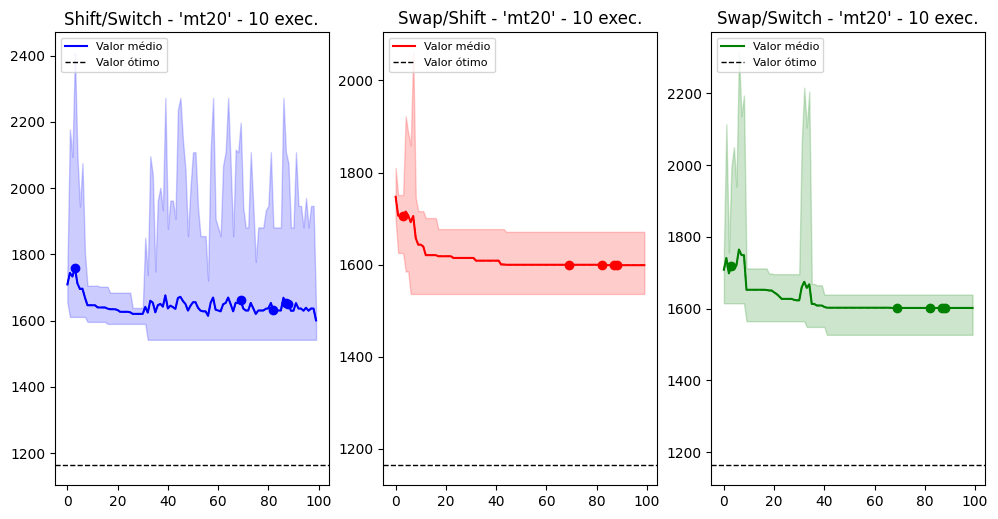

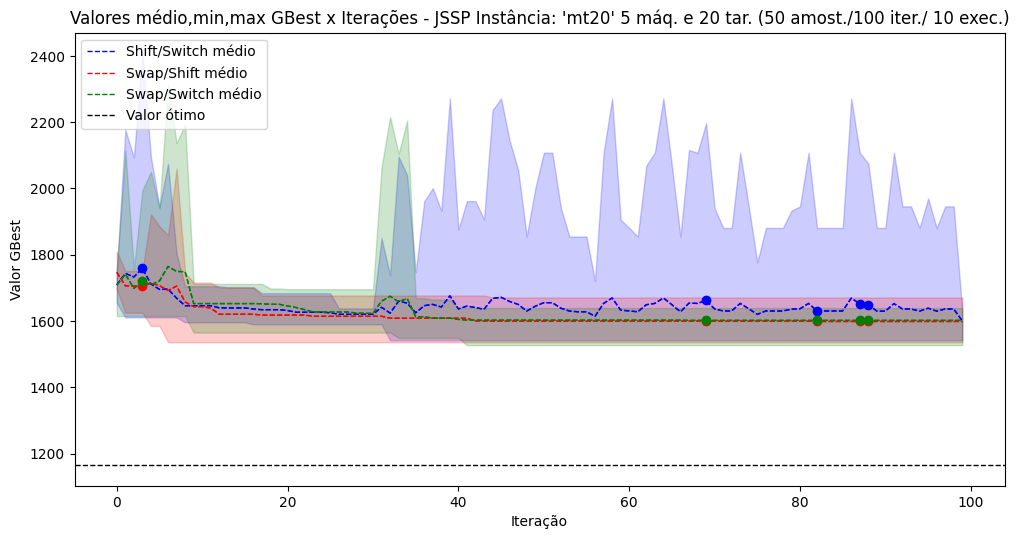

In [139]:
x = np.arange(iterations)
y = np.zeros((sizeNeighborhoodStructure, iterations))
ymin = np.zeros((sizeNeighborhoodStructure, iterations))
ymax = np.zeros((sizeNeighborhoodStructure, iterations))


figHist, axesHist = plt.subplots(1, sizeNeighborhoodStructure, figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    y[ns_it] = meanBestGlobalFitnessArrayPerIteration[ns_it][:]
    ymin[ns_it] = minBestGlobalFitnessArrayPerIteration[ns_it][:]
    ymax[ns_it] = maxBestGlobalFitnessArrayPerIteration[ns_it][:]
    axesHist[ns_it].plot(x, y[ns_it], color=colors[ns_it], label="Valor médio")
    axesHist[ns_it].fill_between(x, ymin[ns_it], ymax[ns_it], color=colors[ns_it], alpha=0.2)
    axesHist[ns_it].axhline(optimalValueArrayJSSPInstance[JSSPInstance], color='k', linestyle='dashed', linewidth=1, label='Valor ótimo')
    axesHist[ns_it].plot(x, y[ns_it], color=colors[ns_it], lw=1, ls='--', marker='o', markevery=iterationsForVND)
    axesHist[ns_it].set_title('{} - \'{}\' - {} exec.'.format(neighborhoodStructuresLiteral[ns_it], JSSPInstance, executionTimeQuantity))
    axesHist[ns_it].legend(fontsize=8, loc='upper left')
    figHist.savefig('./results/%s/linha/desempenhoIndividuais.png' % JSSPInstance, dpi=figHist.dpi)


# Full Figure
figComplete, axesCompleteFig = plt.subplots(figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesCompleteFig.plot(x, y[ns_it], color=colors[ns_it], lw=1, ls='--', label="{} médio".format(neighborhoodStructuresLiteral[ns_it]))
    axesCompleteFig.fill_between(x, ymin[ns_it], ymax[ns_it], color=colors[ns_it], alpha=0.2)
    axesCompleteFig.plot(x, y[ns_it], color=colors[ns_it], lw=1, ls='--', marker='o', markevery=iterationsForVND)

axesCompleteFig.axhline(optimalValueArrayJSSPInstance[JSSPInstance], color='k', linestyle='dashed', linewidth=1, label='Valor ótimo')

axesCompleteFig.set_xlabel('Iteração')
axesCompleteFig.set_ylabel('Valor GBest')
axesCompleteFig.set_title('Valores médio,min,max GBest x Iterações - JSSP Instância: \'{}\' {} máq. e {} tar. ({} amost./{} iter./ {} exec.)'.format(JSSPInstance, machines, tasks, numberOfParticles, iterations, executionTimeQuantity))
axesCompleteFig.legend(fontsize=10, loc='upper left')
figComplete.savefig('./results/%s/linha/desempenhoCompleto.png' % JSSPInstance, dpi=figComplete.dpi)

# 📉 Gráfico - Desempenho normalizado das instâncias (Normalização Linear)

Esta célula deve ser executada após a célula de cálculo de desempenho acima.

In [140]:
minBestGlobalFitnessArrayPerNeighborhoodStructure = np.zeros((sizeNeighborhoodStructure, 1))
maxBestGlobalFitnessArrayPerNeighborhoodStructure = np.zeros((sizeNeighborhoodStructure, executionTimeQuantity))
normalizedBestGlobalFitnessArrayPerIteration = np.zeros((sizeNeighborhoodStructure, iterations, executionTimeQuantity))
meanNormalizedBestGlobalFitnessArrayPerIteration = np.zeros((sizeNeighborhoodStructure, iterations))

for exec_it in range(0, executionTimeQuantity):
    for ns_it in range(0, sizeNeighborhoodStructure):
            maxBestGlobalFitnessArrayPerNeighborhoodStructure[ns_it, exec_it] = executionTimeArrayStoreCopy[ns_it, :, exec_it].max()
            minBestGlobalFitnessArrayPerNeighborhoodStructure[ns_it] = optimalValueArrayJSSPInstance[JSSPInstance]


for exec_it in range(0, executionTimeQuantity):
    for ns_it in range(0, sizeNeighborhoodStructure):
        for it in range(0, iterations):
            normalizedBestGlobalFitnessArrayPerIteration[ns_it, it, exec_it] = calculateLinearNorma(executionTimeArrayStoreCopy[ns_it, it, exec_it], maxBestGlobalFitnessArrayPerNeighborhoodStructure[ns_it, exec_it], minBestGlobalFitnessArrayPerNeighborhoodStructure[ns_it])

for ns_it in range(0, sizeNeighborhoodStructure):
    for it in range(0, iterations):
        meanNormalizedBestGlobalFitnessArrayPerIteration[ns_it, it] = normalizedBestGlobalFitnessArrayPerIteration[ns_it, it, :].mean()


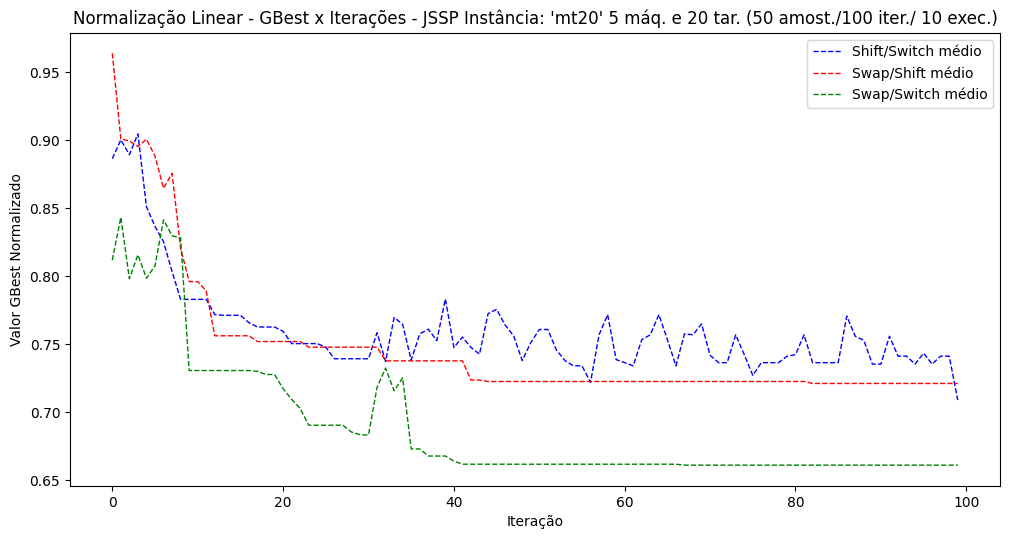

In [141]:
x = np.arange(iterations)
y = np.zeros((sizeNeighborhoodStructure, iterations))

for ns_it in range(0, sizeNeighborhoodStructure):
    y[ns_it] = meanNormalizedBestGlobalFitnessArrayPerIteration[ns_it][:]

# Full Figure
figComplete, axesCompleteFig = plt.subplots(figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesCompleteFig.plot(x, y[ns_it], color=colors[ns_it], lw=1, ls='--', label="{} médio".format(neighborhoodStructuresLiteral[ns_it]))

axesCompleteFig.set_xlabel('Iteração')
axesCompleteFig.set_ylabel('Valor GBest Normalizado')
axesCompleteFig.set_title('Normalização Linear - GBest x Iterações - JSSP Instância: \'{}\' {} máq. e {} tar. ({} amost./{} iter./ {} exec.)'.format(JSSPInstance, machines, tasks, numberOfParticles, iterations, executionTimeQuantity))
axesCompleteFig.legend(fontsize=10, loc='upper right')
figComplete.savefig('./results/%s/desempenhoNormalizado.png' % JSSPInstance, dpi=figComplete.dpi)

## 📈 Gráfico - Histograma Desempenho GBest

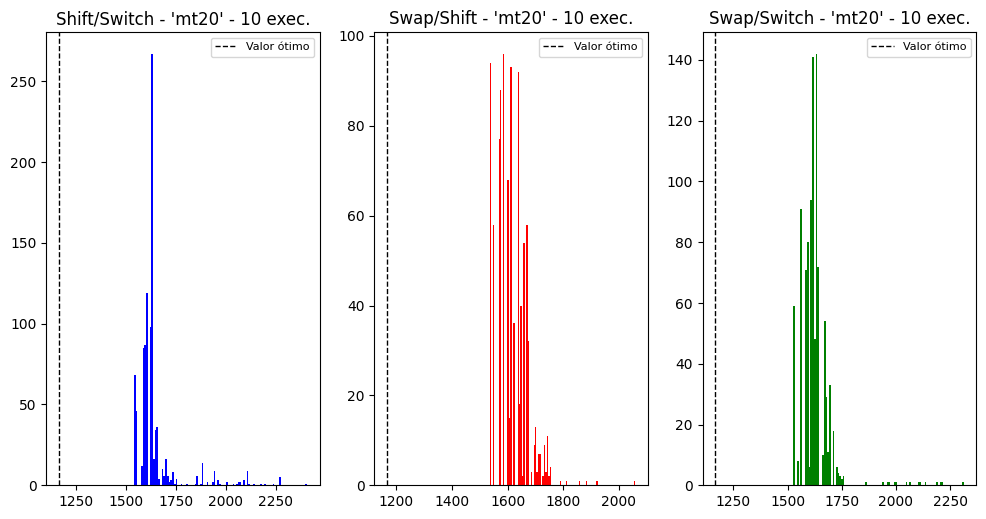

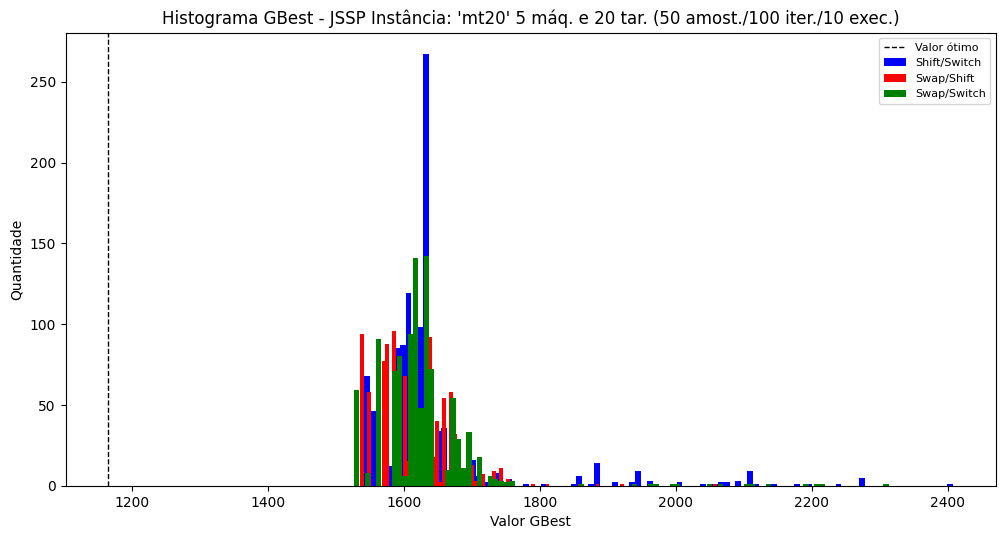

In [142]:
executionTimeArrayStoreCopy = executionTimeArrayStore.reshape(sizeNeighborhoodStructure, iterations*executionTimeQuantity)
nBins = 100

figHist, axesHist = plt.subplots(1, sizeNeighborhoodStructure, figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHist[ns_it].hist(executionTimeArrayStoreCopy[ns_it,:], bins=nBins, color=colors[ns_it])
    # Valor ótimo - Linha Vertical
    axesHist[ns_it].axvline(optimalValueArrayJSSPInstance[JSSPInstance], color='k', linestyle='dashed', linewidth=1, label='Valor ótimo')
    axesHist[ns_it].set_title('{} - \'{}\' - {} exec.'.format(neighborhoodStructuresLiteral[ns_it], JSSPInstance, executionTimeQuantity))
    axesHist[ns_it].legend(fontsize=8)
    figHist.savefig('./results/%s/histograma/desempenhoIndividuais.png' % JSSPInstance, dpi=figHist.dpi)


# Full figure
figHistComplete, axesHistComplete = plt.subplots(figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHistComplete.hist(executionTimeArrayStoreCopy[ns_it,:], bins=nBins, color=colors[ns_it], label=neighborhoodStructuresLiteral[ns_it])

# Valor ótimo - Linha Vertical
axesHistComplete.axvline(optimalValueArrayJSSPInstance[JSSPInstance], color='k', linestyle='dashed', linewidth=1, label='Valor ótimo')

axesHistComplete.set_ylabel('Quantidade')
axesHistComplete.set_xlabel('Valor GBest')
axesHistComplete.set_title('Histograma GBest - JSSP Instância: \'{}\' {} máq. e {} tar. ({} amost./{} iter./{} exec.)'.format(JSSPInstance,machines, tasks, numberOfParticles, iterations, executionTimeQuantity))
axesHistComplete.legend(fontsize=8)
figHistComplete.savefig('./results/%s/histograma/desempenhoCompleto.png' % JSSPInstance, dpi=figHistComplete.dpi)

## 📈 Gráfico - Histograma das média das posições candidatas diversas ao longo das iterações 

### Cálculo da diversidade entre as soluções ao longo das iterações

In [143]:
diversitySamplesBetweenIterations = np.zeros((sizeNeighborhoodStructure, iterations, executionTimeQuantity))
meanDiversitySamplesBetweenIterations = np.zeros((sizeNeighborhoodStructure, iterations))

for exec_it in range(0, executionTimeQuantity):
    for ns_it in range(0, sizeNeighborhoodStructure):
        for it in range(0, iterations):
            diversitySamplesBetweenIterations[ns_it][it][exec_time_it] = analyzeDiversityBetweenSamples(executionTimeArrayStoreVector[:, :, ns_it, it - 1, exec_time_it], executionTimeArrayStoreVector[:, :, ns_it, it, exec_time_it], it)

for ns_it in range(0, sizeNeighborhoodStructure):
    for it in range(0, iterations):
        meanDiversitySamplesBetweenIterations[ns_it][it] = diversitySamplesBetweenIterations[ns_it][it][:].mean()

### Plot individual e completo

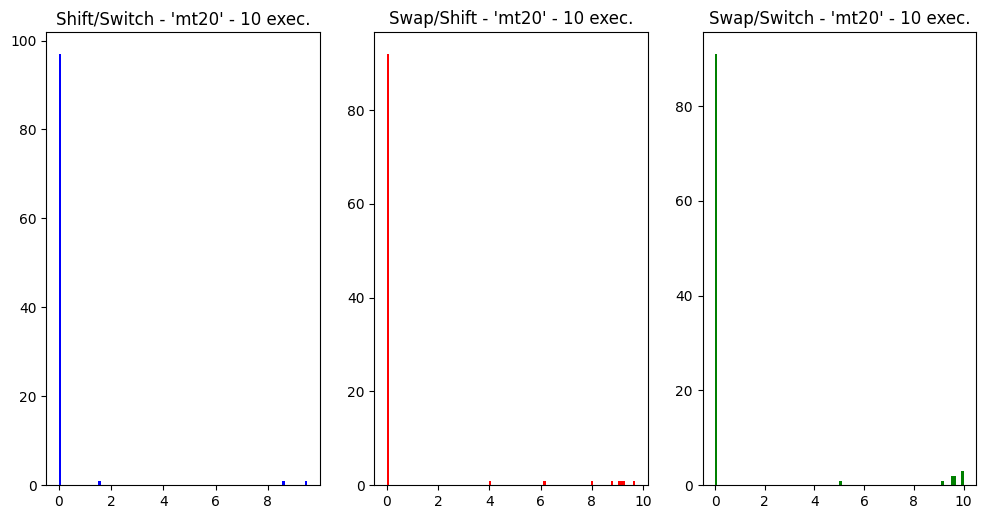

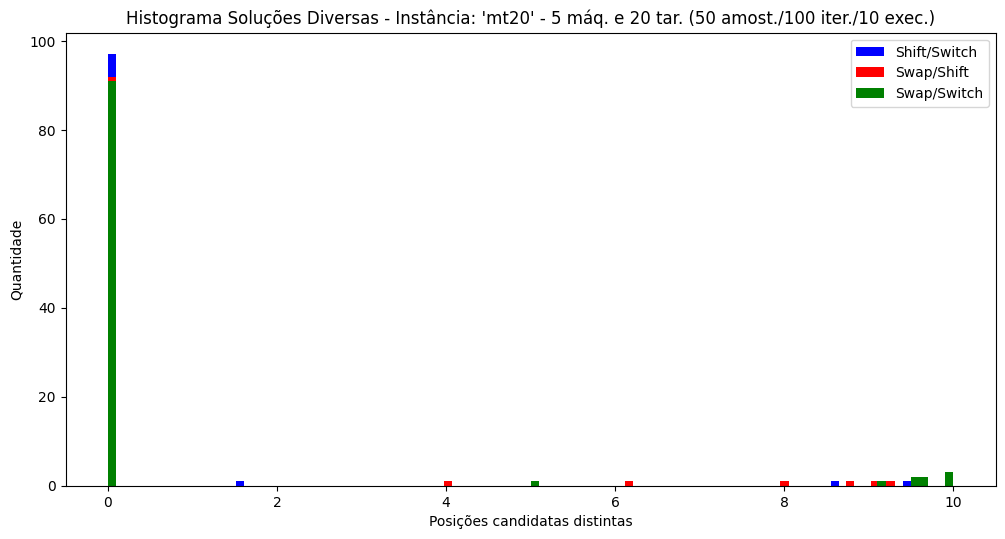

In [144]:
nBins = 100

figHistDiversity, axesHistDiversity = plt.subplots(1, sizeNeighborhoodStructure, figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHistDiversity[ns_it].hist(meanDiversitySamplesBetweenIterations[ns_it][:], bins=nBins, color=colors[ns_it])
    axesHistDiversity[ns_it].set_title('{} - \'{}\' - {} exec.'.format(neighborhoodStructuresLiteral[ns_it], JSSPInstance, executionTimeQuantity))
    figHistDiversity.savefig('./results/%s/histograma/diversidadeIndividuais.png' % JSSPInstance, dpi=figHistDiversity.dpi)


# Full figure
figHistCompleteDiversity, axesHistCompleteDiversity = plt.subplots(figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHistCompleteDiversity.hist(meanDiversitySamplesBetweenIterations[ns_it,:], bins=nBins, color=colors[ns_it], label=neighborhoodStructuresLiteral[ns_it])

axesHistCompleteDiversity.set_ylabel('Quantidade')
axesHistCompleteDiversity.set_xlabel('Posições candidatas distintas')
axesHistCompleteDiversity.set_title('Histograma Soluções Diversas - Instância: \'{}\' - {} máq. e {} tar. ({} amost./{} iter./{} exec.)'.format(JSSPInstance,machines, tasks, numberOfParticles, iterations, executionTimeQuantity))
axesHistCompleteDiversity.legend(fontsize=10)
figHistCompleteDiversity.savefig('./results/%s/histograma/diversidadeCompleto.png' % JSSPInstance, dpi=figHistCompleteDiversity.dpi)

## 📈 Gráfico - Histograma Erro Relativo (Individual e Completo) com respectivos valores médios

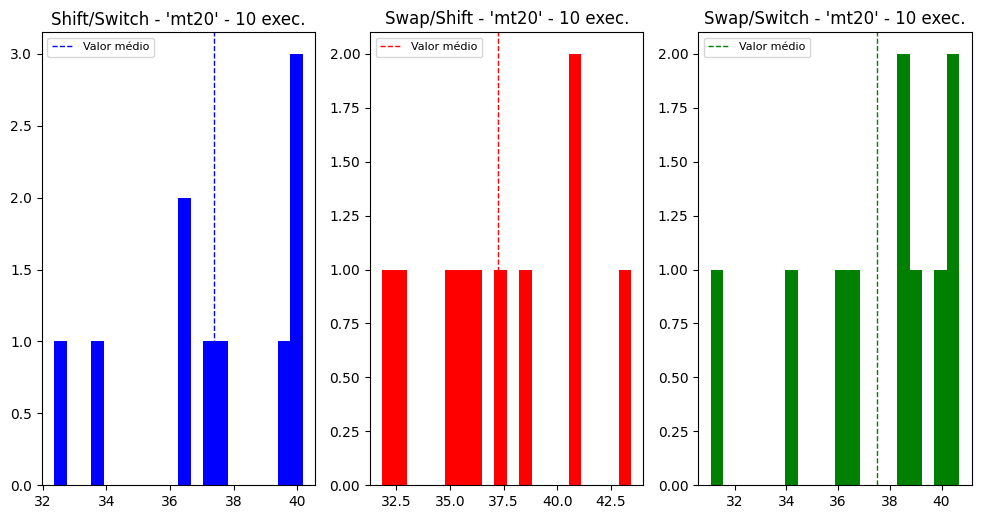

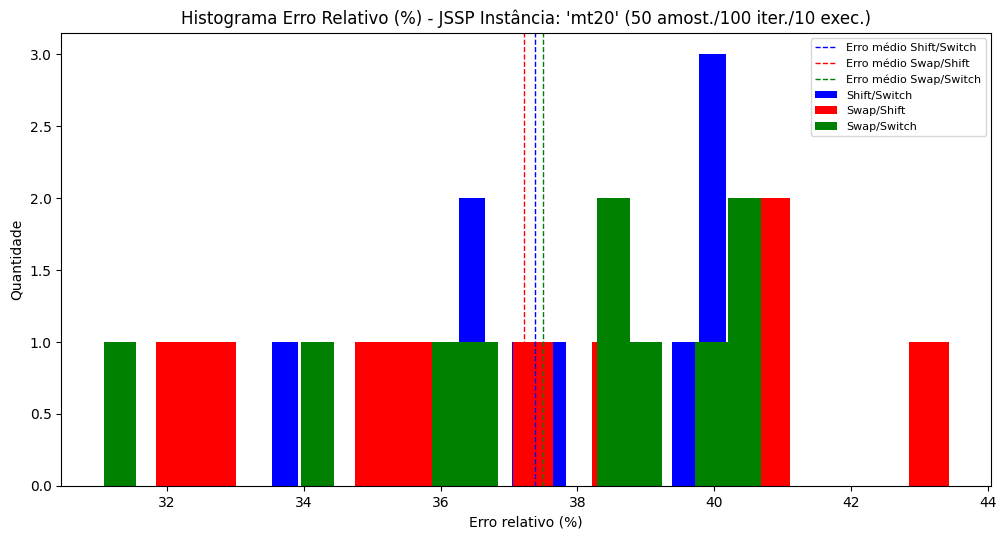

In [145]:
# Individual Analysis
nBins = 20
figHistRelativeErrorIndividual, axesHistRelativeErrorIndividual = plt.subplots(1, sizeNeighborhoodStructure, figsize=(12,6), dpi=100)
executionTimeArrayStoreCopy = executionTimeArrayStore.reshape(sizeNeighborhoodStructure, iterations*executionTimeQuantity)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHistRelativeErrorIndividual[ns_it].hist(relativeErrorPercentage[ns_it,:], bins=nBins, color=colors[ns_it])
    # Erro relativo médio - Linha Vertical
    axesHistRelativeErrorIndividual[ns_it].axvline(meanRelativeErrorPercentage[ns_it], color=colors[ns_it], linestyle='dashed', linewidth=1, label='Valor médio')
    axesHistRelativeErrorIndividual[ns_it].set_title('{} - \'{}\' - {} exec.'.format(neighborhoodStructuresLiteral[ns_it], JSSPInstance, executionTimeQuantity))
    axesHistRelativeErrorIndividual[ns_it].legend(fontsize=8)
    figHistRelativeErrorIndividual.savefig('./results/%s/histograma/errorIndividuais.png' % JSSPInstance, dpi=figHistRelativeErrorIndividual.dpi)


# Complete Analysis
figHistRelativeErrorComplete, axesHistRelativeErrorComplete = plt.subplots(figsize=(12,6), dpi=100)

for ns_it in range(0, sizeNeighborhoodStructure):
    axesHistRelativeErrorComplete.hist(relativeErrorPercentage[ns_it,:], bins=nBins, color=colors[ns_it], label=neighborhoodStructuresLiteral[ns_it])
    # Erro relativo médio - Linha Vertical
    axesHistRelativeErrorComplete.axvline(meanRelativeErrorPercentage[ns_it], color=colors[ns_it], linestyle='dashed', linewidth=1, label='Erro médio {}'.format(neighborhoodStructuresLiteral[ns_it]))
    

axesHistRelativeErrorComplete.set_ylabel('Quantidade')
axesHistRelativeErrorComplete.set_xlabel('Erro relativo (%)')
axesHistRelativeErrorComplete.set_title('Histograma Erro Relativo (%) - JSSP Instância: \'{}\' ({} amost./{} iter./{} exec.)'.format(JSSPInstance, numberOfParticles, iterations, executionTimeQuantity))
axesHistRelativeErrorComplete.legend(fontsize=8)
figHistRelativeErrorComplete.savefig('./results/%s/histograma/errorCompleto.png' % JSSPInstance, dpi=figHistRelativeErrorComplete.dpi)